## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
from sklearn import metrics
from sklearn import cluster
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import median_absolute_error

#Для корректного отображения графиков в ноутбуках используется команда %matplotlib inline
%matplotlib inline

# для корректного отображения графиков на тёмном фоне
plt.style.use('default')

Прочитаем наш файл с исходными данными:

In [2]:
taxi_data = pd.read_csv("data/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок.

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определите временные рамки (без учета времени), за которые представлены данные.

In [3]:
td = taxi_data.copy()

# Переведем признак pickup_datetime в тип данных 'datetime'
td['pickup_datetime'] = pd.to_datetime(td['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

# определяем минимальную и максимальную дату
min_date = td['pickup_datetime'].min().date()
max_date = td['pickup_datetime'].max().date()

print('Дата начала: ', min_date)
print('Дата конца: ', max_date)

Дата начала:  2016-01-01
Дата конца:  2016-06-30


### Задание 2.2
Посмотрим на пропуски. 
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [4]:
print(f'Количество пропущенных значений: {td.isnull().sum().sum()}')

Количество пропущенных значений: 0


### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков. 

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [5]:
print(f'Количество уникальных таксопарков: {td.vendor_id.nunique()}')
print(f'Максимальное количество пассажиров: {td.passenger_count.max()}')

print(f'Средняя длительность поездки (в секундах):{round(td.trip_duration.mean())}')
print(f'Медианная длительность поездки (в секундах): {round(td.trip_duration.median())}')

print(f'Минимальное время поездки (в секундах): {td.trip_duration.min()}')
print(f'Максимальное время поездки (в секундах): {td.trip_duration.max()}')

Количество уникальных таксопарков: 2
Максимальное количество пассажиров: 9
Средняя длительность поездки (в секундах):959
Медианная длительность поездки (в секундах): 662
Минимальное время поездки (в секундах): 1
Максимальное время поездки (в секундах): 3526282


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


### Задание 2.4
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - наименование дня недели, в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [6]:
def add_datetime_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Добавляет новые временные признаки
    :param df:  таблица с данными о поездках (DataFrame)
    :return: таблица с добавленными признаками (DataFrame)
    """

    if df.pickup_datetime.dtype == 'object':
        df.pickup_datetime = pd.to_datetime(df.pickup_datetime, format='%Y-%m-%d %H:%M:%S')

    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.dayofweek

    return df


# Вызов функции add_datetime_features() на вашем DataFrame
td = add_datetime_features(td)

print(f'Количество поездок в субботу: {td[td.pickup_day_of_week==5].shape[0]}')
print(f'Среднее количество поездок в день {round(td.pickup_date.value_counts().mean())}')

Количество поездок в субботу: 220868
Среднее количество поездок в день 8015


### Задание 2.5
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.


In [7]:
def add_holiday_features(df: pd.DataFrame, holiday_df: pd.DataFrame) -> pd.DataFrame:
    """
    Добавляет новый бинарный признак того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет)
    :param df: таблица с данными о поездках
    :param holiday_df: таблица с данными о праздничных днях
    :return: таблица с добавленными признаками (DataFrame)
    """

    holiday_dates = pd.to_datetime(holiday_df.date, format='%Y-%m-%d').dt.date
    df['pickup_holiday'] = df['pickup_date'].isin(holiday_dates)

    return df


holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')
td = add_holiday_features(td, holiday_data)

print("Медианная длительность поездки на такси в праздничные дни: ", round(td[td.pickup_holiday == 1].trip_duration.median()))

Медианная длительность поездки на такси в праздничные дни:  585


### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [8]:
def add_osrm_features(df: pd.DataFrame, osrm_df: pd.DataFrame) -> pd.DataFrame:
    """
    Добавляет новые признаки - данные OSRM
    :param df: таблица с данными о поездках
    :param osrm_df: таблица с данными OSRM
    :return: таблица с добавленными признаками (DataFrame)
    """

    # Выделение интересующих нас столбцов из таблицы osrm_df
    osrm_columns = osrm_df[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]

    # Объединение таблиц по столбцу id с типом объединения left
    df = df.merge(osrm_columns, on='id', how='left')

    return df


osrm_data = pd.read_csv('data/osrm_data_train.csv')
td = add_osrm_features(td, osrm_data)

print(f'Разница медианной длительности поездки, сек: {round(td.trip_duration.median() - td.total_travel_time.median())}')
print('Количество пропусков:', td.total_distance.isnull().sum())

Разница медианной длительности поездки, сек: 372
Количество пропусков: 1


In [9]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [10]:
def add_geographical_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Добавляет новые признаки - географические данные
    :param df: таблица с данными о поездках
    :return: таблица с добавленными признаками (DataFrame)
    """
    df['haversine_distance'] = get_haversine_distance(df.pickup_latitude, df.pickup_longitude, df.dropoff_latitude, df.dropoff_longitude)
    df['direction'] = get_angle_direction(df.pickup_latitude, df.pickup_longitude, df.dropoff_latitude, df.dropoff_longitude)
    return df


td = add_geographical_features(td)

# median haversine distance (in kilometers)
print(f'Медианное расстояние Хаверсина: {round(td.haversine_distance.median(), 2)}')

Медианное расстояние Хаверсина: 2.09


### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [11]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))

# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

KMeans(n_clusters=10, random_state=42)

In [12]:
def add_cluster_features(df: pd.DataFrame, kmeans_alg: cluster.KMeans) -> pd.DataFrame:
    """
    Добавляет новый признак - географический кластер, к которому относится поездка
    :param df: таблица с данными о поездках
    :param kmeans_alg: обученный алгоритм кластеризации
    :return: таблица с добавленными признаками (DataFrame)
    """

    df['geo_cluster'] = kmeans_alg.predict(
        np.hstack((df[['pickup_latitude', 'pickup_longitude']],
                   df[['dropoff_latitude', 'dropoff_longitude']]))
    )

    return df


td = add_cluster_features(td, kmeans)

print(f'В наименьшем по размеру географическом кластере  {td.geo_cluster.value_counts().min()} поездок')

В наименьшем по размеру географическом кластере  2 поездок


### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [13]:
def add_weather_features(df: pd.DataFrame, df_weather: pd.DataFrame) -> pd.DataFrame:
    """
    Добавляет новый признак - погодные данные
    :param df: таблица с данными о поездках
    :param df_weather: таблица с данными о погодных условиях на каждый час
    :return: таблица с добавленными признаками (DataFrame)
    """

    dfw=df_weather[['temperature', 'visibility', 'wind speed',
                                 'precip', 'events', 'time']].copy()

    dfw['time'] = pd.to_datetime(dfw['time'], format='%Y-%m-%d %H:%M:%S')
    dfw['date'] = dfw['time'].dt.date
    dfw['hour'] = dfw['time'].dt.hour
    dfw = dfw.drop(['time'], axis=1)

    df = df.merge(dfw,
        left_on=['pickup_date', 'pickup_hour'],
        right_on=['date', 'hour'], how='left')
    df = df.drop(['date', 'hour'], axis=1)

    return df

weather_data = pd.read_csv('data/weather_data.csv')
td = add_weather_features(td, weather_data)

print('Количество поездок в снежную погоду', td[td.events == 'Snow'].shape[0])

empty_weather_count=td[td[['temperature','visibility','wind speed', 'precip', 'events']].isna().any(axis=1)].shape[0]/td.shape[0]*100
print('Пропусков в столбцах с погодными условиями:', round(empty_weather_count, 2))

Количество поездок в снежную погоду 13126
Пропусков в столбцах с погодными условиями: 0.82


### Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски.
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана).

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам.

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [14]:
def fill_null_weather_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Заполняет пропуски в датафрейме
    :param df: таблица с данными о поездках
    :return: таблица с заполненными пропусками
    """

    df.temperature = df.temperature.fillna(df.groupby('pickup_date').temperature.transform('median'))
    df.visibility = df.visibility.fillna(df.groupby('pickup_date').visibility.transform('median'))
    df['wind speed'] = df['wind speed'].fillna(df.groupby('pickup_date')['wind speed'].transform('median'))
    df.precip = df.precip.fillna(df.groupby('pickup_date').precip.transform('median'))

    df['events'] = df['events'].fillna('None')

    df['total_distance'] = df['total_distance'].fillna(df['total_distance'].median())
    df['total_travel_time'] = df['total_travel_time'].fillna(df['total_travel_time'].median())
    df['number_of_steps'] = df['number_of_steps'].fillna(df['number_of_steps'].median())

    return df


td = fill_null_weather_data(td)
print("Медиана в столбце temperature:", round(td['temperature'].median(),1))

Медиана в столбце temperature: 11.1


В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


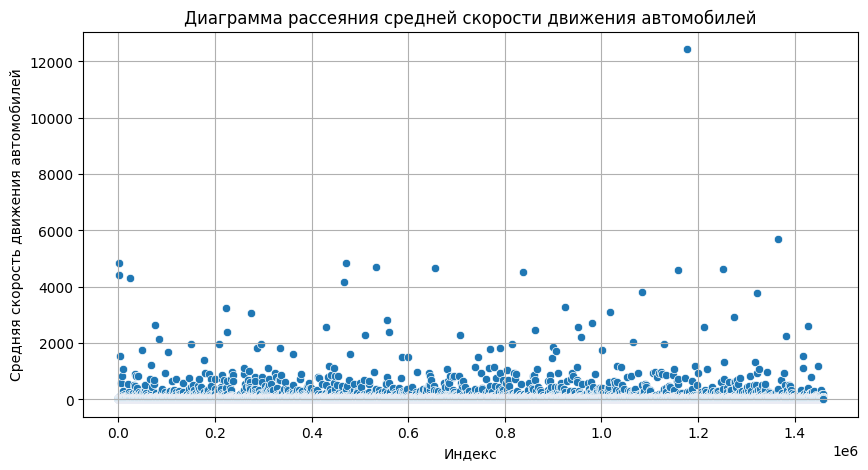

In [17]:
avg_speed = td['total_distance'] / td['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.grid(True)
ax.set_title('Диаграмма рассеяния средней скорости движения автомобилей')
ax.set_xlabel('Индекс')
ax.set_ylabel('Средняя скорость движения автомобилей');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных. 

б) Сколько выбросов по признаку скорости вам удалось найти?

In [18]:
print('Выбросов по признаку длительности поездки:', td[td['trip_duration'] > 24*60*60].shape[0])
print('Выбросов по признаку скорости:', avg_speed[avg_speed > 300].shape[0])

# Удалим выбросы по признаку длительности поездки больше 300 км/ч
td=td.drop(index=td[(td['trip_duration'] > 24*60*60) | (td['total_distance']/td['trip_duration'] * 3.6 > 300)].index, axis=0)

Выбросов по признаку длительности поездки: 4
Выбросов по признаку скорости: 407


## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [19]:
td['trip_duration_log'] = np.log(td['trip_duration']+1)

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным? 
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

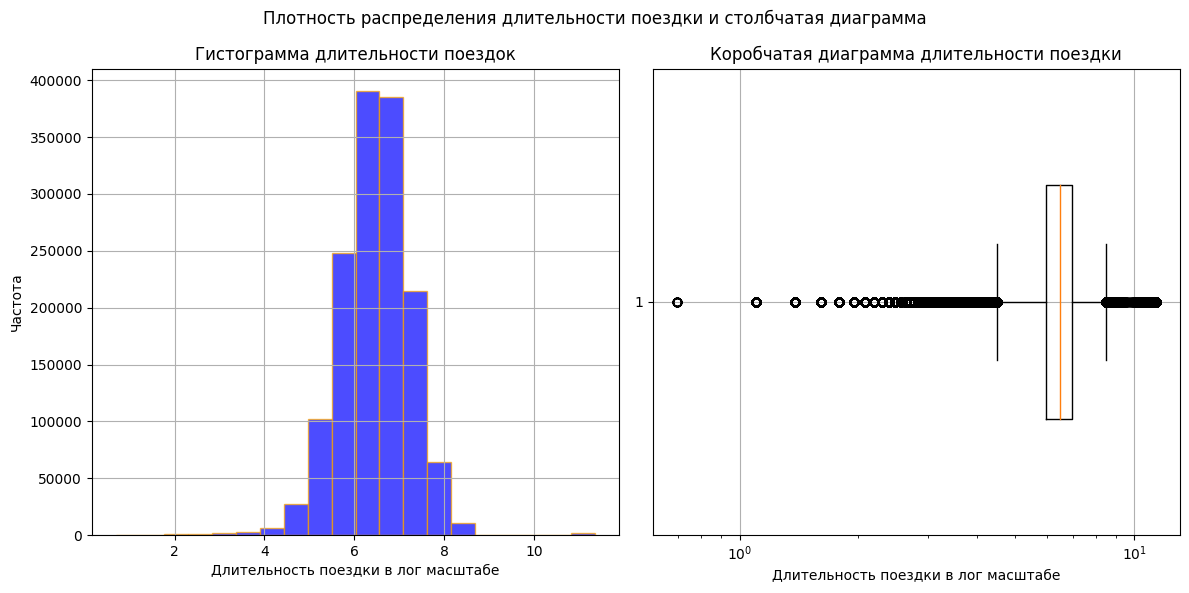

In [20]:
_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax1.hist(td['trip_duration_log'], bins=20, color='blue', edgecolor = 'orange', alpha=0.7)
ax1.set_xlabel('Длительность поездки в лог масштабе')
ax1.set_ylabel('Частота')
ax1.set_title('Гистограмма длительности поездок')
ax1.grid(True)

ax2.boxplot(td['trip_duration_log'], vert=False, widths=0.5)
ax2.set_xlabel('Длительность поездки в лог масштабе')
ax2.set_xscale('log')
ax2.set_title('Коробчатая диаграмма длительности поездки')
ax2.grid(True)

plt.suptitle('Плотность распределения длительности поездки и столбчатая диаграмма')
plt.tight_layout()
plt.show();

In [21]:
from scipy.stats import normaltest


# Проверим гипотезу с помощью теста Д’Агостино при уровне значимости alpha=0.05
# H0: распределение нормальное
# H1: распределение не нормальное
stat, pvalue = normaltest(td['trip_duration_log'])
print(f'p-value равен: {round(pvalue, 2)}')

alpha = 0.05
if pvalue > alpha:
    print('Распределение нормальное (нулевая гипотеза H0 не может быть отвергнута)')
else:
    print('Распределение  не похоже на нормальное (нулевая гипотеза H0 может быть отвергнута)')

p-value равен: 0.0
Распределение  не похоже на нормальное (нулевая гипотеза H0 может быть отвергнута)


### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравните два распределения между собой.

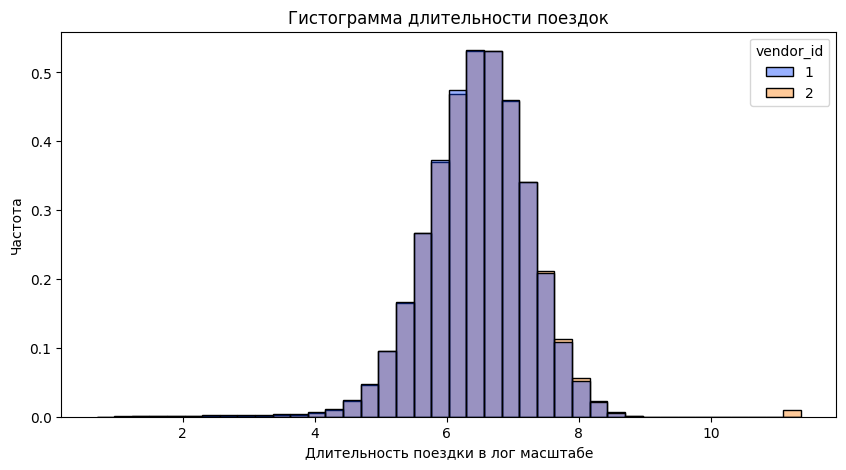

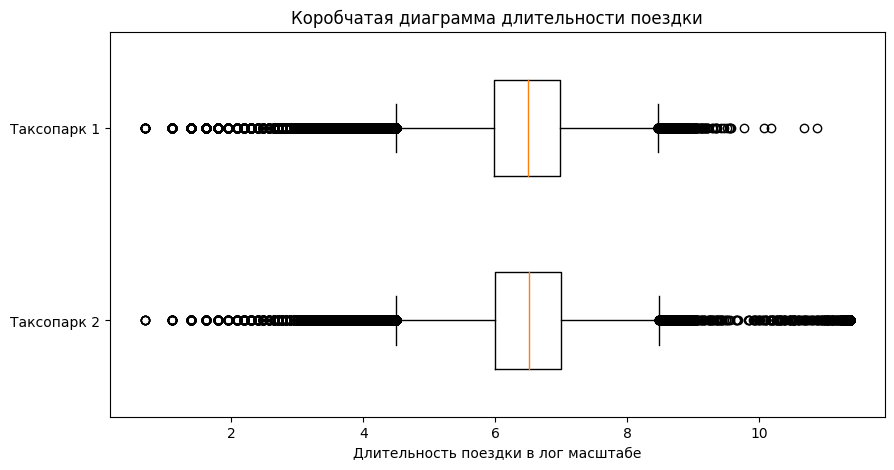

In [22]:
fig=plt.figure(figsize=(10, 5))
sns.histplot(data=td,
             x="trip_duration_log",
             hue="vendor_id",
             palette = "bright",
             alpha = 0.4,
             bins=40,
             stat="density",
             common_norm=False)
plt.title("Гистограмма длительности поездок")
plt.xlabel("Длительность поездки в лог масштабе")
plt.ylabel("Частота")

# Построение ящика с усами для каждого таксопарка
fig=plt.figure(figsize=(10, 5))
plt.boxplot([td[td['vendor_id'] == 2]['trip_duration_log'],
            td[td['vendor_id'] == 1]['trip_duration_log']],vert=False, widths=0.5, labels=['Таксопарк 2', 'Таксопарк 1'] )
plt.xlabel('Длительность поездки в лог масштабе')
plt.title('Коробчатая диаграмма длительности поездки')

plt.show();

Распределение в группах практически не отличаются. Можно предположить, что признак `vendor_id` не влияет на длительность поездки.

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

Сравните два распределения между собой.

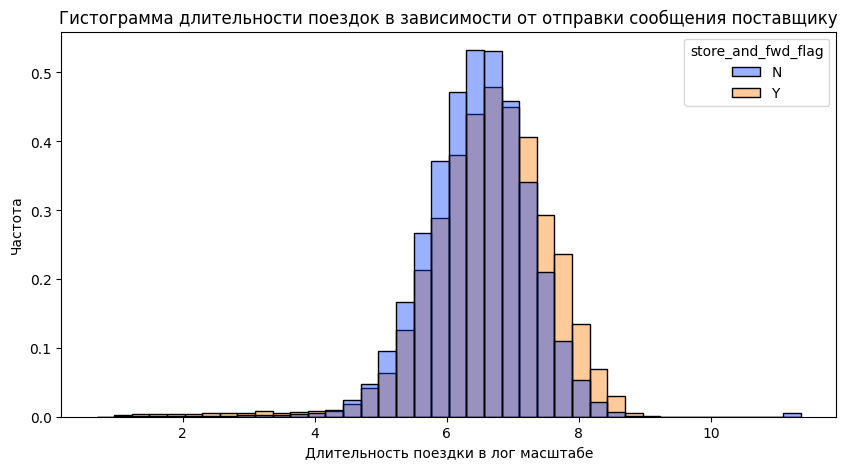

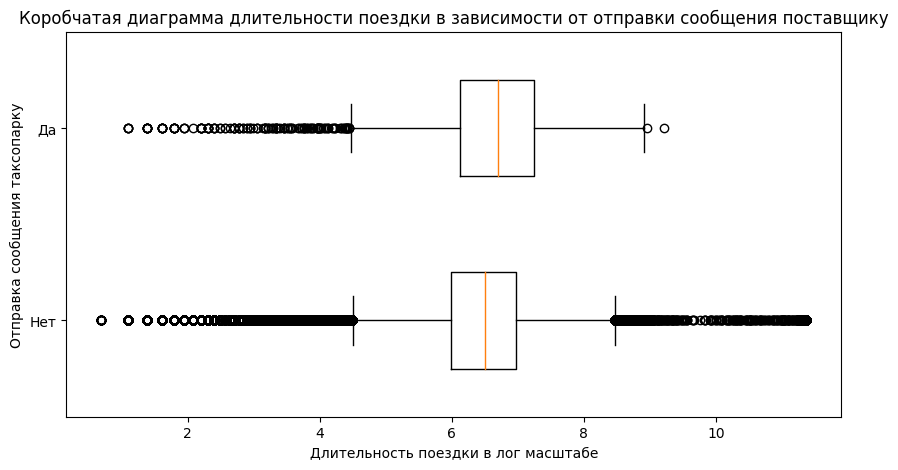

In [23]:
fig=plt.figure(figsize=(10, 5))
sns.histplot(data=td,
             x="trip_duration_log",
             hue="store_and_fwd_flag",
             palette = "bright",
             alpha =0.4,
             bins=40,
            fill=True,
             stat="density",
             common_norm=False
             )
plt.title("Гистограмма длительности поездок в зависимости от отправки сообщения поставщику")
plt.xlabel("Длительность поездки в лог масштабе")
plt.ylabel("Частота")

# Построение ящика с усами для каждого таксопарка
fig=plt.figure(figsize=(10, 5))
plt.boxplot([td[td['store_and_fwd_flag'] == 'N']['trip_duration_log'],
            td[td['store_and_fwd_flag'] == 'Y']['trip_duration_log']],vert=False, widths=0.5, labels=['Нет', 'Да'] )
plt.xlabel('Длительность поездки в лог масштабе')
plt.ylabel('Отправка сообщения таксопарку')
plt.title('Коробчатая диаграмма длительности поездки в зависимости от отправки сообщения поставщику')

plt.show();

Распределение в группах незначительно отличаются, признак "отправка сообщению поставщику" имеет небольшое влияние на длительность поездки.

### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

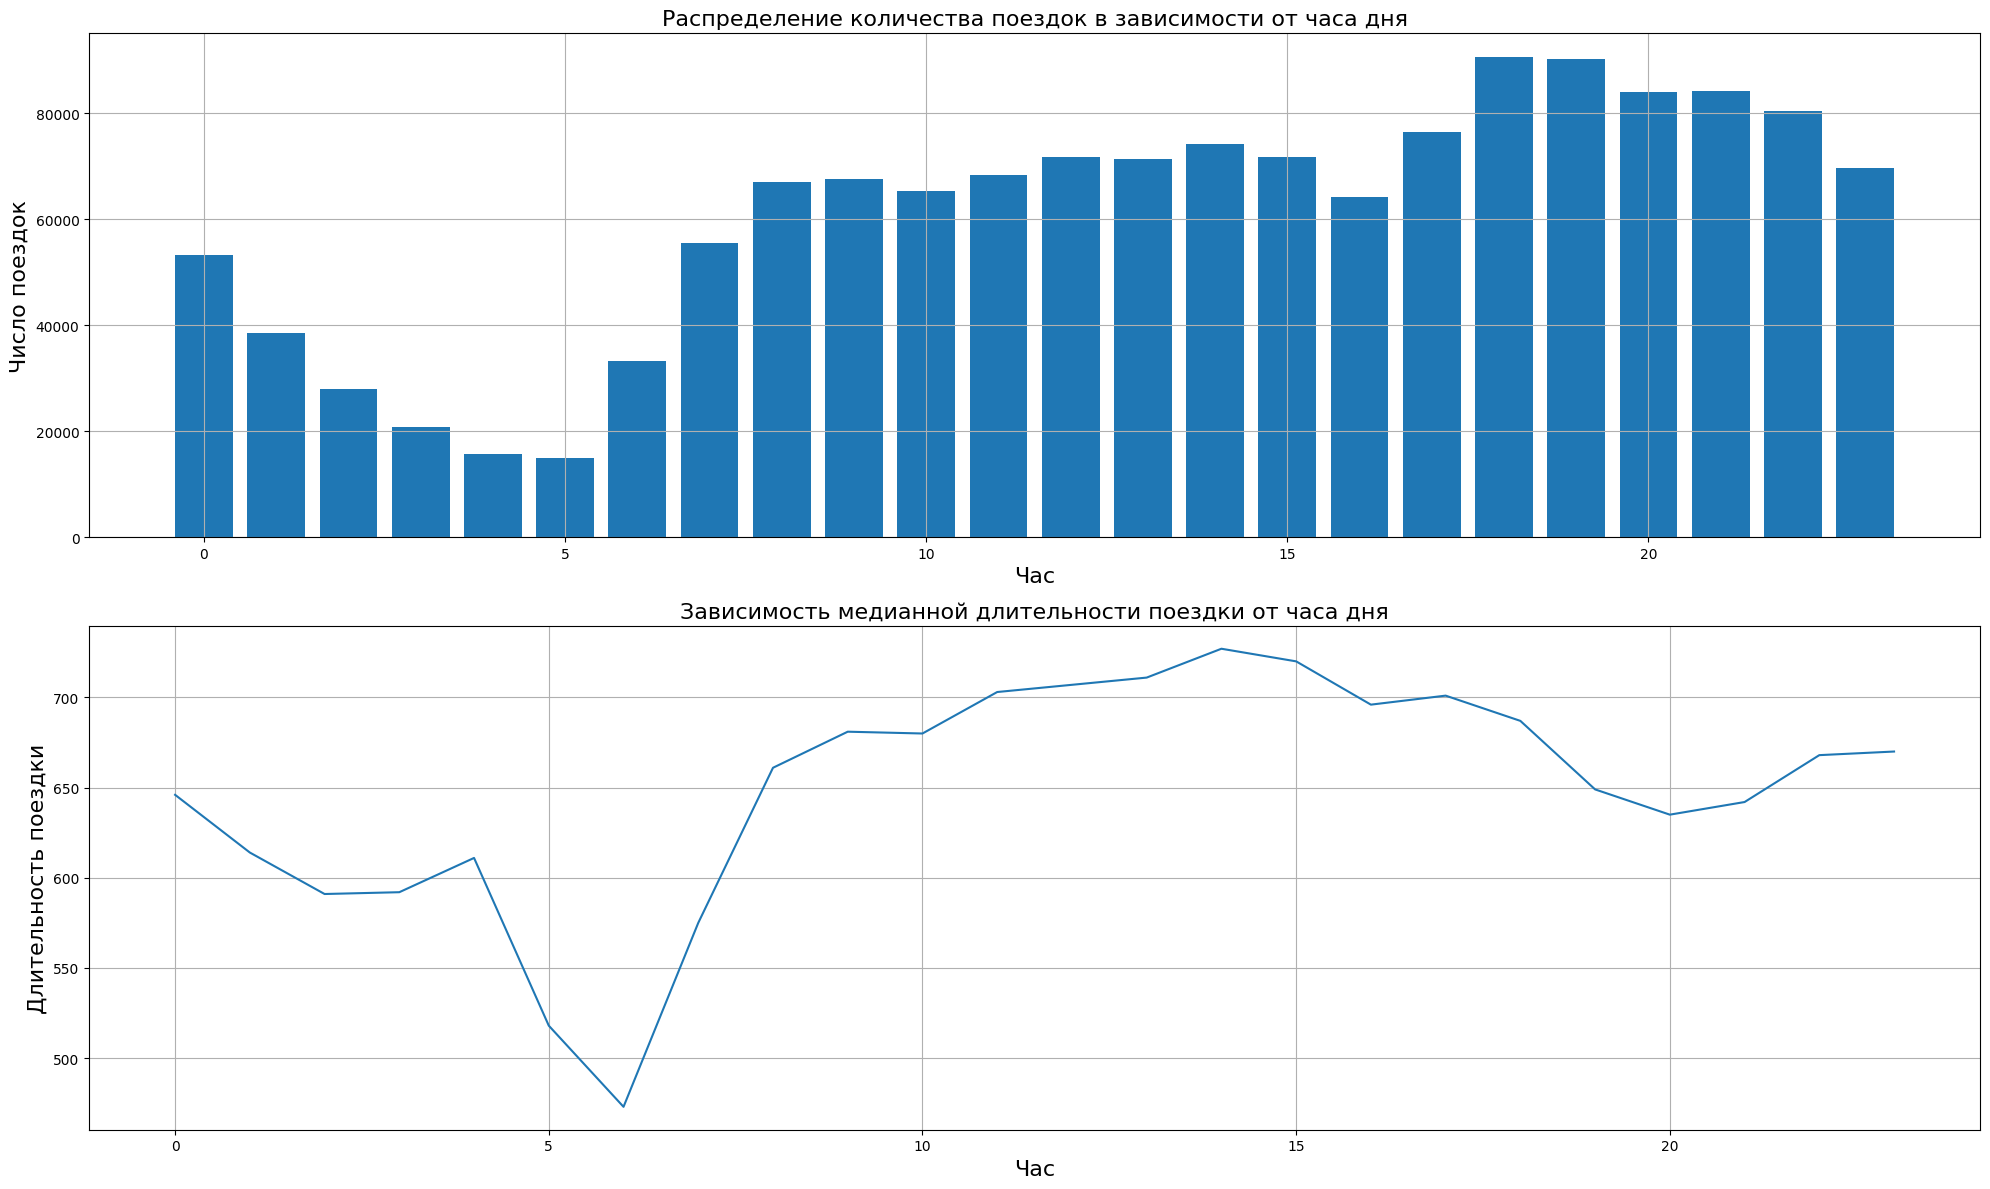

In [24]:
pickup_hours=td['pickup_hour'].value_counts().sort_index()
median_duration_by_hour = td.groupby('pickup_hour')['trip_duration'].median().sort_index()

_, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 12))

ax1.bar(pickup_hours.index, pickup_hours.values)
ax1.set_xlabel('Час', fontsize=16)
ax1.set_ylabel('Число поездок', fontsize=16)
ax1.set_title('Распределение количества поездок в зависимости от часа дня', fontsize=16)
ax1.grid(True)

ax2.plot(median_duration_by_hour.index, median_duration_by_hour.values)
ax2.set_xlabel('Час', fontsize=16)
ax2.set_ylabel('Длительность поездки', fontsize=16)
ax2.set_title('Зависимость медианной длительности поездки от часа дня', fontsize=16)
ax2.grid(True)

plt.tight_layout()
plt.show();

### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


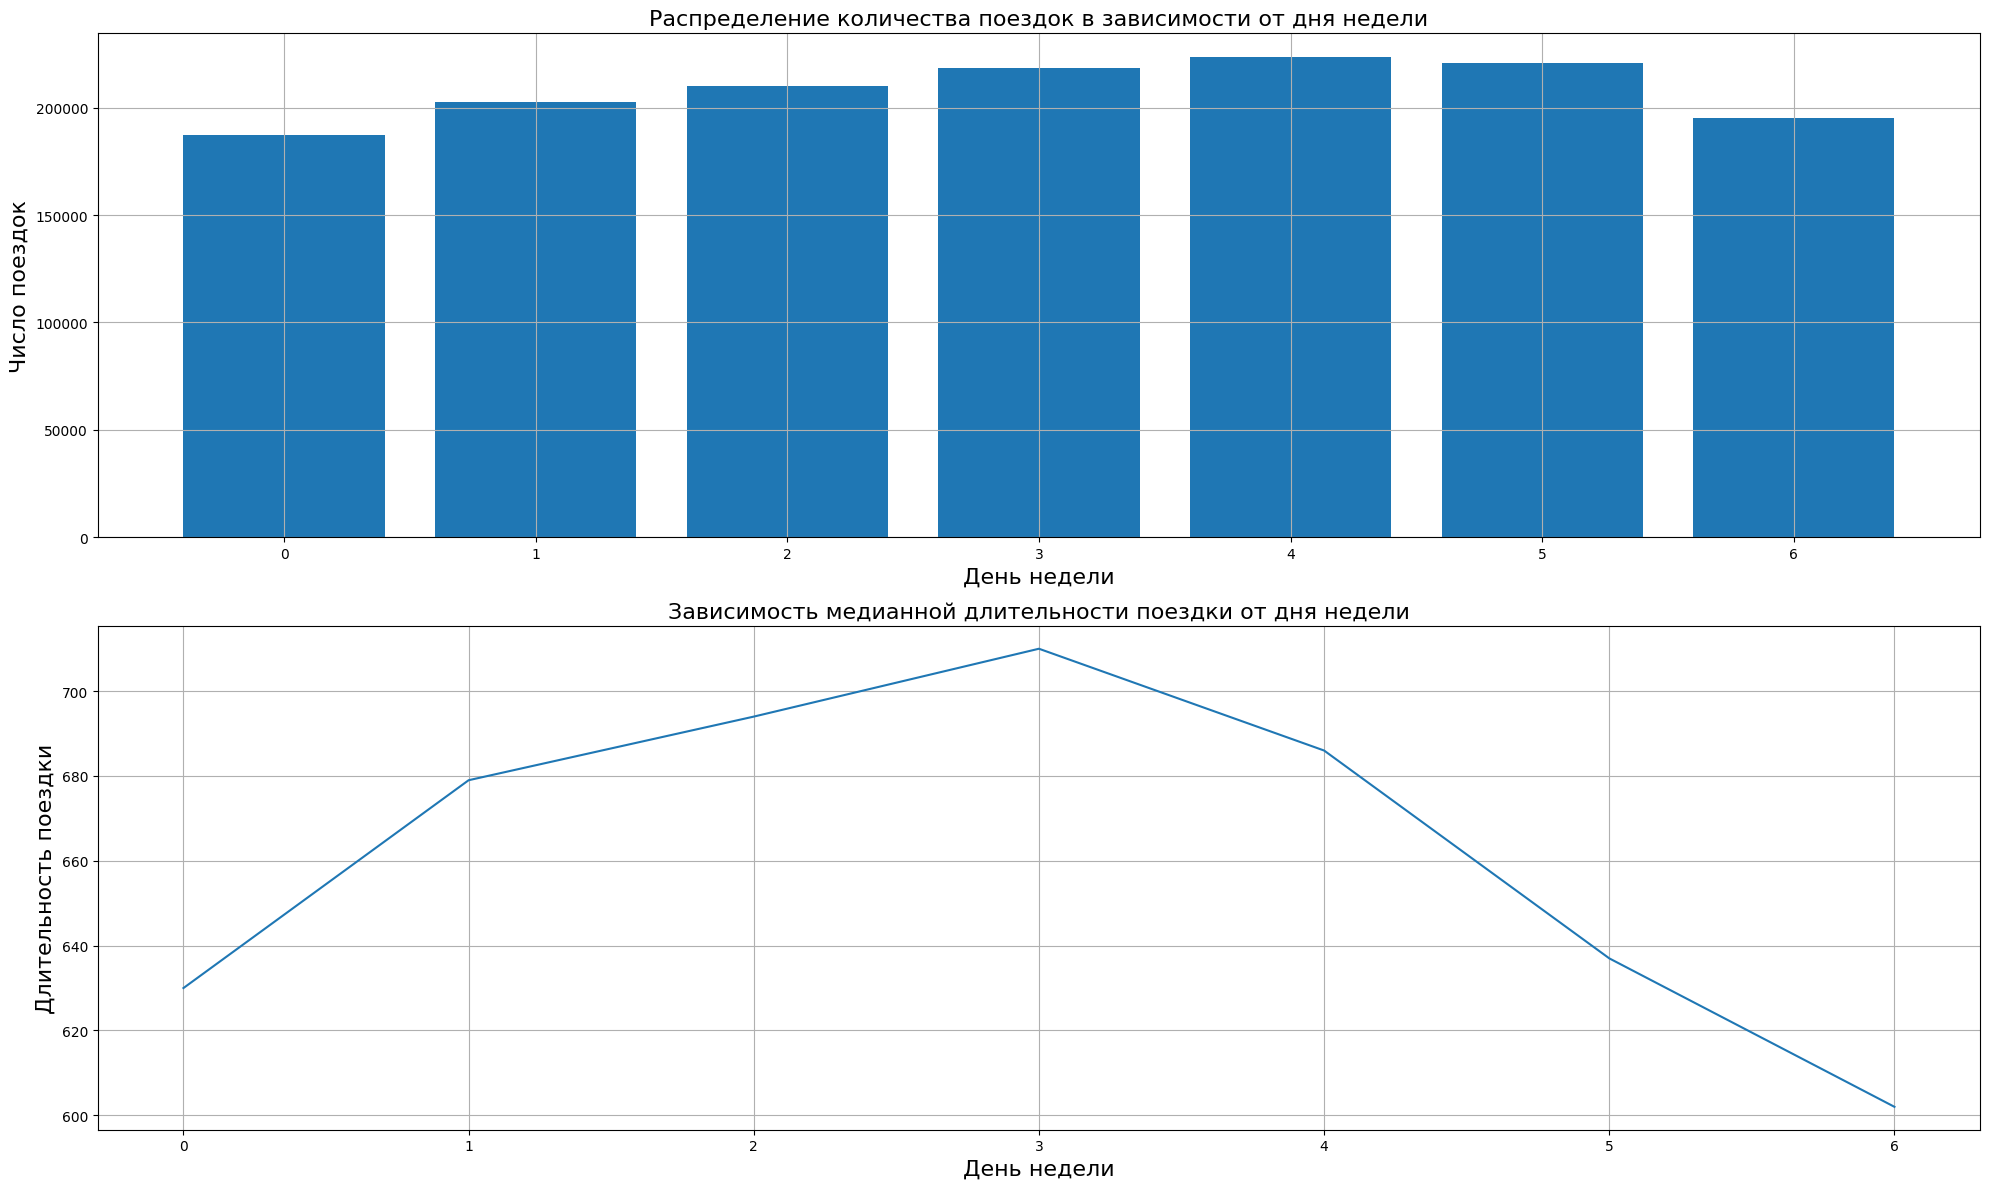

In [128]:
pickup_hours=td['pickup_day_of_week'].value_counts().sort_index()
median_duration_by_hour = td.groupby('pickup_day_of_week')['trip_duration'].median().sort_index()

_, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 12))

ax1.bar(pickup_hours.index, pickup_hours.values)
ax1.set_xlabel('День недели', fontsize=16)
ax1.set_ylabel('Число поездок', fontsize=16)
ax1.set_title('Распределение количества поездок в зависимости от дня недели', fontsize=16)
ax1.grid(True)

ax2.plot(median_duration_by_hour.index, median_duration_by_hour.values)
ax2.set_xlabel('День недели', fontsize=16)
ax2.set_ylabel('Длительность поездки', fontsize=16)
ax2.set_title('Зависимость медианной длительности поездки от дня недели', fontsize=16)
ax2.grid(True)

plt.tight_layout()
plt.show();

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно. 

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

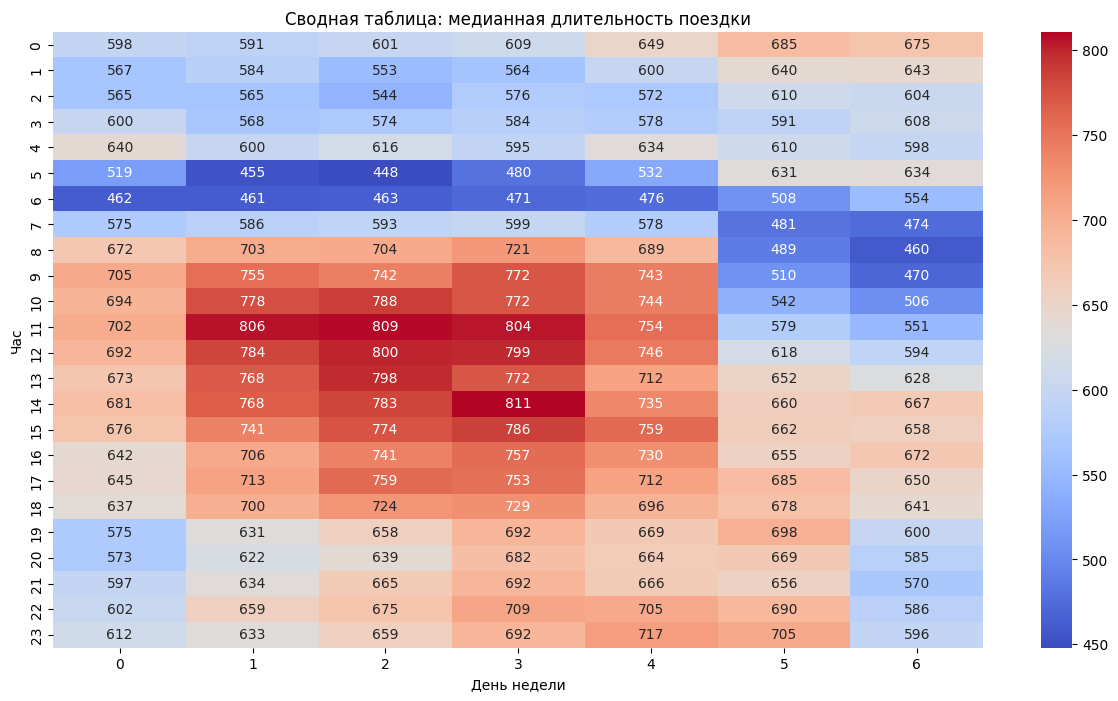

In [25]:
# Создание сводной таблицы
time_features_table = td.pivot_table(values='trip_duration', index='pickup_hour', columns='pickup_day_of_week', aggfunc='median')

# Создание тепловой карты
plt.figure(figsize=(15, 8))
sns.heatmap(time_features_table, cmap='coolwarm', annot=True, fmt='.0f')
plt.xlabel('День недели')
plt.ylabel('Час')
plt.title('Сводная таблица: медианная длительность поездки')

# Отображение тепловой карты
plt.show()

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude). 
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


/home/svs/data/projects/python/urfu/homeworks/env/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/svs/data/projects/python/urfu/homeworks/env/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


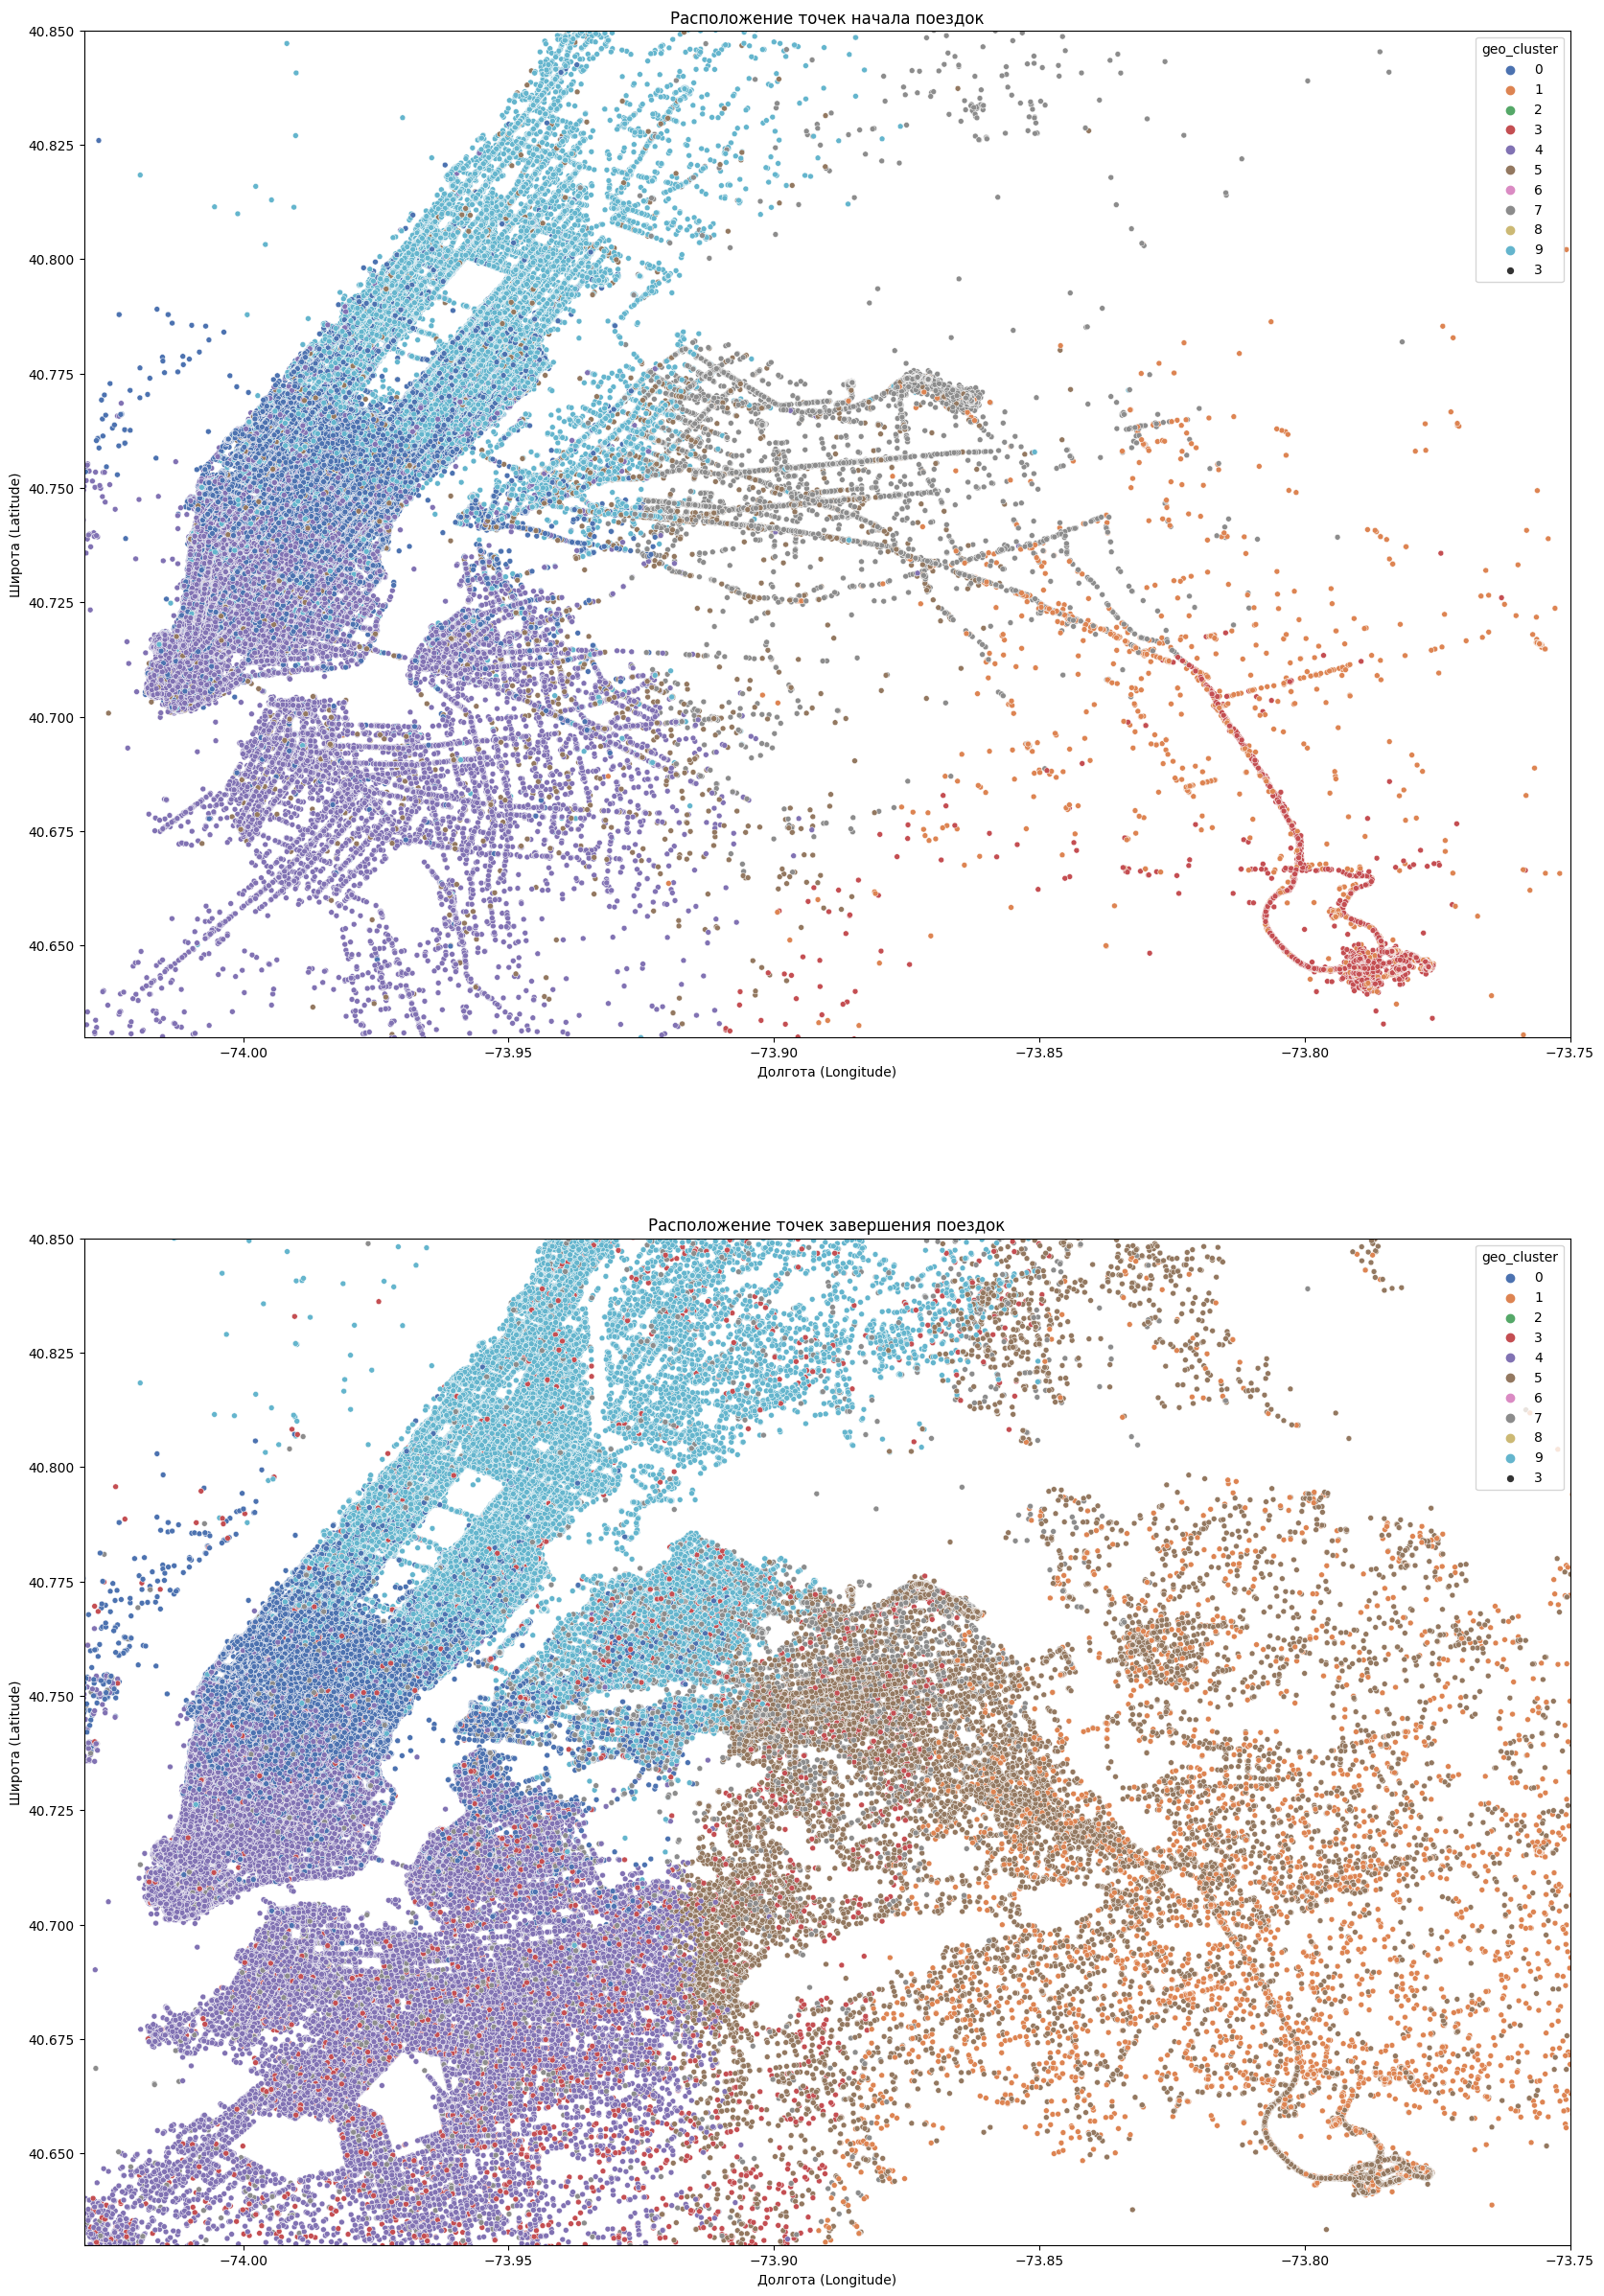

In [26]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

_, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 30))

sns.scatterplot(x='pickup_longitude', y='pickup_latitude', data=td, hue='geo_cluster', ax=ax1, size=3, palette="deep")
ax1.set_title('Расположение точек начала поездок')
ax1.set_xlim(city_long_border)
ax1.set_ylim(city_lat_border)
ax1.set_xlabel('Долгота (Longitude)')
ax1.set_ylabel('Широта (Latitude)');

sns.scatterplot(x='dropoff_longitude', y='dropoff_latitude', data=td, hue='geo_cluster', ax=ax2, size=3, palette="deep")
ax2.set_title('Расположение точек завершения поездок')
ax2.set_xlim(city_long_border)
ax2.set_ylim(city_lat_border)
ax2.set_xlabel('Долгота (Longitude)')
ax2.set_ylabel('Широта (Latitude)');

In [27]:
all_clusters_size = np.unique(td.geo_cluster).size
plotted_clusters_size = np.unique(td.loc[ (td.pickup_longitude >= city_long_border[0]) &
                                             (td.pickup_longitude <= city_long_border[1]) &
                                             (td.pickup_latitude >= city_lat_border[0]) &
                                             (td.pickup_latitude <= city_lat_border[1]) ,
                                             'geo_cluster' ]).size
unplotted_clusters = all_clusters_size - plotted_clusters_size

print(f'{unplotted_clusters} кластера не показаны на точечной диаграмме.')

2 кластера не показаны на точечной диаграмме.


## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [28]:
print('Shape of data: {}'.format(td.shape))
print('Columns: {}'.format(td.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [29]:
train_data = td.copy()
train_data.head()

id  vendor_id     pickup_datetime     dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  ...  number_of_steps  \
0         40.765602                  N  ...              5.0   
1         40.731152                  N  ...              6.0   
2         40.710087                  N  ...             16.0   
3         40.706718                  N  ...              4.0   
4         40.782520                  N  ...              5.0   

  haversine_distance   direction  geo_cluster  temperature  visibility  \
0           1.498521   99.970196            9          4.4         8.0   
1           1.805507 -117.153768            4         28.9        16.1   
2           6.385098 -159.680165            4         -6.7        16.1   
3           1.485498 -172.737700            4          7.2        16.1   
4           1.188588  179.473585            9          9.4        16.1   

   wind speed  precip  events  trip_duration_log  
0        27.8     0.3    None           6.122493  
1         7.4     0.0    None           6.498282  
2        24.1     0.0    None           7.661527  
3        25.9     0.0    None           6.063785  
4         9.3     0.0    None           6.077642  

[5 rows x 27 columns]

### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Утечка данных (data leak) - это…

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?


In [30]:
# Удаляем столбцы id и dropoff_time из исходной таблицы с данными
train_data = train_data.drop(['id', 'dropoff_datetime'], axis=1)

print(f'В таблице осталось {train_data.shape[1]} столбцов')

В таблице осталось 25 столбцов


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [31]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)

print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


### Задание 4.2.

Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [32]:
train_data['vendor_id'] = train_data['vendor_id'].map({1: 0, 2: 1})
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].map({'N': 0, 'Y': 1})

print('Среднее по столбцу vendor_id', round(train_data['vendor_id'].mean(), 2))
print('Среднее по столбцу store_and_fwd_flag', round(train_data['store_and_fwd_flag'].mean(), 3))

Среднее по столбцу vendor_id 0.53
Среднее по столбцу store_and_fwd_flag 0.006


### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEncoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events. 


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [33]:
one_hot_encoder = OneHotEncoder(drop='first')

columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']

# применяем кодирование, результат переводим в массив
data_onehot = one_hot_encoder.fit_transform(train_data[columns_to_change]).toarray()
# получаем имена закодированных столбцов
column_names = one_hot_encoder.get_feature_names_out()
# составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)

print('Сгенерировано бинарных столбцов:', data_onehot.shape[1])

Сгенерировано бинарных столбцов: 18


Добавим полученную таблицу с закодированными признаками:

In [34]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot],
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [35]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [36]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [37]:
# Отбор лучших 25 признаков с помощью SelectKBest
selector = SelectKBest(score_func=f_regression, k=25)
selector.fit(X_train, y_train_log)

best_features = selector.get_feature_names_out()
X_train = X_train[best_features]
X_valid = X_valid[best_features]

print(f'Отобранные признаки:\n{best_features}')

Отобранные признаки:
['vendor_id' 'passenger_count' 'pickup_longitude' 'pickup_latitude'
 'dropoff_longitude' 'dropoff_latitude' 'store_and_fwd_flag' 'pickup_hour'
 'pickup_holiday' 'total_distance' 'total_travel_time' 'number_of_steps'
 'haversine_distance' 'temperature' 'pickup_day_of_week_1'
 'pickup_day_of_week_2' 'pickup_day_of_week_3' 'pickup_day_of_week_4'
 'pickup_day_of_week_5' 'pickup_day_of_week_6' 'geo_cluster_1'
 'geo_cluster_3' 'geo_cluster_5' 'geo_cluster_7' 'geo_cluster_9']


Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [38]:
# Создаём объект класса MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

print('Среднее арифметическое для 1 предиктора валидационной выборки: ',
      round(X_valid_scaled[:, 0].mean(), 2))

Среднее арифметическое для 1 предиктора валидационной выборки:  0.54


## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [39]:
# создаём объект класса LinearRegression
linear_model = LinearRegression()

# обучаем модель
linear_model.fit(X_train_scaled, y_train_log)

# делаем предсказания
y_train_pred = linear_model.predict(X_train_scaled)
y_valid_pred = linear_model.predict(X_valid_scaled)

# рассчитываем RMSLE
rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred))
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred))

print('RMSLE на тренировочной выборке', round(rmsle_train, 2))
print('RMSLE на валидационной выборке', round(rmsle_valid, 2))

RMSLE на тренировочной выборке 0.54
RMSLE на валидационной выборке 0.54


### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [40]:
# создаём генератор полиномиальных признаков
poly = PolynomialFeatures(degree=2, include_bias=False)

# обучаем модель
poly.fit(X_train_scaled)

# генерируем полиномиальные признаки
X_train_poly = poly.transform(X_train_scaled)
X_valid_poly = poly.transform(X_valid_scaled)

# создаём объект класса LinearRegression
linear_model = LinearRegression()

# обучаем модель
linear_model.fit(X_train_poly, y_train_log)

# делаем предсказания
y_train_pred = linear_model.predict(X_train_poly)
y_valid_pred = linear_model.predict(X_valid_poly)

# рассчитываем RMSLE
rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred))
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred))

print('RMSLE на тренировочной выборке', round(rmsle_train, 2))
print('RMSLE на валидационной выборке', round(rmsle_valid, 2))

RMSLE на тренировочной выборке 0.47
RMSLE на валидационной выборке 0.7


### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha$ установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [41]:
# создаём генератор полиномиальных признаков
poly = PolynomialFeatures(degree=2, include_bias=False)

# обучаем модель
poly.fit(X_train_scaled)

# генерируем полиномиальные признаки
X_train_poly = poly.transform(X_train_scaled)
X_valid_poly = poly.transform(X_valid_scaled)

# создаём объект класса Ridge
ridge_model = Ridge(alpha=1)

# обучаем модель
ridge_model.fit(X_train_poly, y_train_log)

# делаем предсказания
y_train_pred = ridge_model.predict(X_train_poly)
y_valid_pred = ridge_model.predict(X_valid_poly)

# рассчитываем RMSLE
rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred))
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred))

print('RMSLE на тренировочной выборке', round(rmsle_train, 2))
print('RMSLE на валидационной выборке', round(rmsle_valid, 2))

RMSLE на тренировочной выборке 0.48
RMSLE на валидационной выборке 0.48


### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию. 

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [42]:
# создаём объект класса DecisionTreeRegressor
tree_model = DecisionTreeRegressor(random_state=42)

# обучаем модель
tree_model.fit(X_train_scaled, y_train_log)

# делаем предсказания
y_train_pred = tree_model.predict(X_train_scaled)
y_valid_pred = tree_model.predict(X_valid_scaled)

# рассчитываем RMSLE
rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred))
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred))

print('RMSLE на тренировочной выборке', round(rmsle_train, 2))
print('RMSLE на валидационной выборке', round(rmsle_valid, 2))

RMSLE на тренировочной выборке 0.0
RMSLE на валидационной выборке 0.57


### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Параметр random_state задайте равным 42.

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


In [43]:
# все возможные варианты глубины дерева решений в диапазоне от 7 до 20
max_depths = range(7, 20)

# создаём пустые списки, в которые будем добавлять результаты
rmsle_train, rmsle_valid = [], []

# Переберите все возможные варианты глубины дерева решений
for depth in max_depths:
    # создаём объект класса DecisionTreeRegressor
    tree_model = DecisionTreeRegressor(max_depth=depth,random_state=42)

    # обучаем модель
    tree_model.fit(X_train_scaled, y_train_log)

    # делаем предсказания
    y_train_pred = tree_model.predict(X_train_scaled)
    y_valid_pred = tree_model.predict(X_valid_scaled)

    # рассчитываем RMSLE
    rmsle_train.append(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred)))
    rmsle_valid.append(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred)))

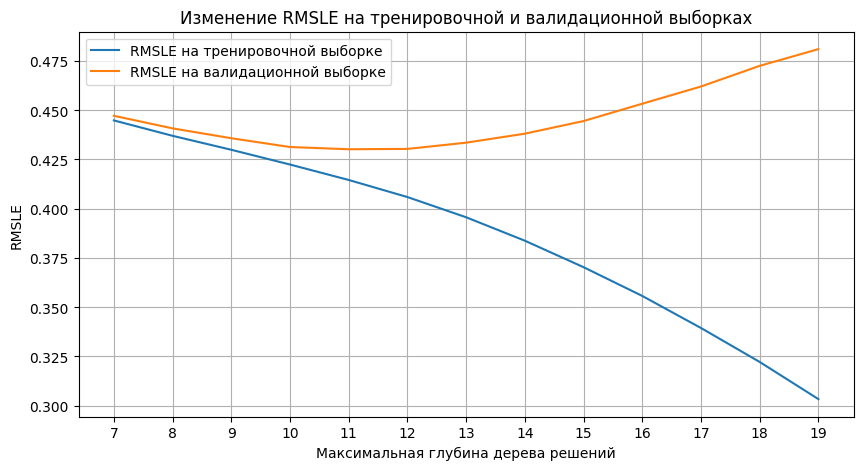

In [44]:
# визуализируем
fig=plt.figure(figsize=(10, 5))
plt.plot(max_depths, rmsle_train, label='RMSLE на тренировочной выборке')
plt.plot(max_depths, rmsle_valid, label='RMSLE на валидационной выборке')
plt.title('Изменение RMSLE на тренировочной и валидационной выборках')
plt.xlabel('Максимальная глубина дерева решений')
plt.ylabel('RMSLE')
plt.xticks(max_depths)
plt.legend()
plt.grid()
plt.show()

In [45]:
#индекс лучшего RMSLE на валидационной выборке
best_index = rmsle_valid.index(min(rmsle_valid))

print('Оптимальная глубина дерева решений:', max_depths[best_index+1])
print('RMSLE на тренировочной выборке:', round(rmsle_train[best_index], 2))
print('RMSLE на валидационной выборке:', round(rmsle_valid[best_index], 2))

Оптимальная глубина дерева решений: 12
RMSLE на тренировочной выборке: 0.41
RMSLE на валидационной выборке: 0.43


## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [46]:
# создаём объект класса RandomForestRegressor
rfr_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    criterion='squared_error',
    min_samples_split=20,
    random_state=42,
    verbose=True,
    n_jobs=-1
)

# обучаем модель
rfr_model.fit(X_train_scaled, y_train_log)

# делаем предсказания
y_train_pred = rfr_model.predict(X_train_scaled)
y_valid_pred = rfr_model.predict(X_valid_scaled)

# рассчитываем RMSLE
rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred))
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred))

print('RMSLE на тренировочной выборке', round(rmsle_train, 2))
print('RMSLE на валидационной выборке', round(rmsle_valid, 2))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    1.5s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    1.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s


RMSLE на тренировочной выборке 0.4
RMSLE на валидационной выборке 0.41


[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.9s finished


### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [47]:
# создаём объект класса GradientBoostingRegressor
gb_model  = GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6,
    min_samples_split=30,
    random_state=42,
    verbose=True
)

# обучаем модель
gb_model.fit(X_train_scaled, y_train_log)

# делаем предсказания
y_train_pred = gb_model.predict(X_train_scaled)
y_valid_pred = gb_model.predict(X_valid_scaled)

# рассчитываем RMSLE
rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred))
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred))

print('RMSLE на тренировочной выборке', round(rmsle_train, 4))
print('RMSLE на валидационной выборке', round(rmsle_valid, 4))

      Iter       Train Loss   Remaining Time 
         1           0.3110            7.54m
         2           0.2247            7.18m
         3           0.1987            7.04m
         4           0.1876            6.93m
         5           0.1823            6.86m
         6           0.1783            6.77m
         7           0.1756            6.71m
         8           0.1730            6.62m
         9           0.1709            6.60m
        10           0.1696            6.52m
        20           0.1577            5.93m
        30           0.1538            5.17m
        40           0.1502            4.43m
        50           0.1480            3.71m
        60           0.1451            2.98m
        70           0.1431            2.23m
        80           0.1410            1.48m
        90           0.1393           44.28s
       100           0.1383            0.00s
RMSLE на тренировочной выборке 0.3718
RMSLE на валидационной выборке 0.3941


### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


Наименьшее значение RMSLE на валидационной выборке получилось у модели градиентный бустинг с результатом RMSLE 0.39 на валидационной выборке

### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


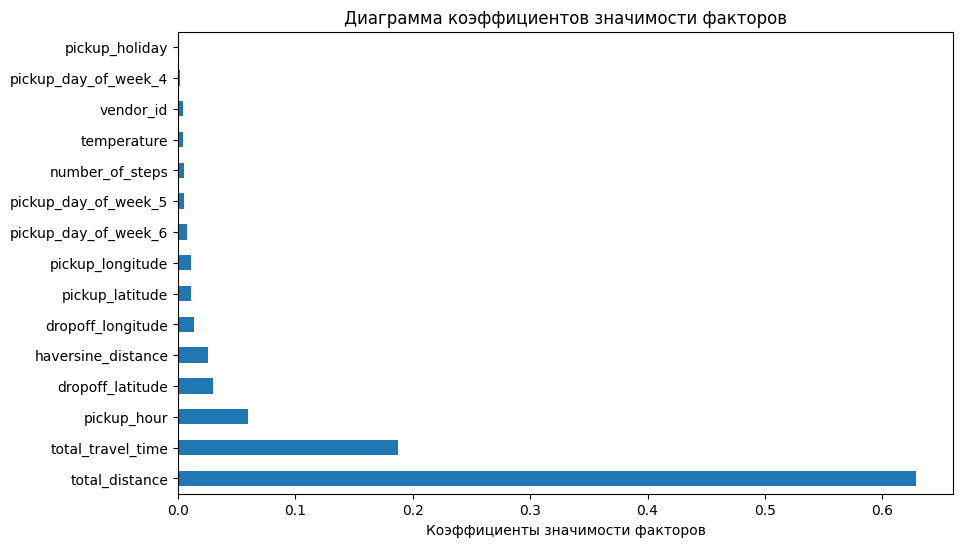

In [48]:
plt.figure(figsize=(10, 6))
feature_importances = pd.Series(gb_model.feature_importances_, index=best_features)
feature_importances.nlargest(15).plot(kind='barh')
plt.xlabel('Коэффициенты значимости факторов')
plt.title('Диаграмма коэффициентов значимости факторов')
plt.show()

### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [49]:
# переводим из логарифимического масштаба в исходный
y_valid = np.exp(y_valid_log) - 1
y_valid_pred_exp = np.exp(y_valid_pred) - 1

# рассчитываем медианную абсолютную ошибку
meae_valid = median_absolute_error(y_valid, y_valid_pred_exp)

# переводим значение метрики в минуты и округляем
print(f'MeAE на валидационной выборке: {round(meae_valid / 60, 1)} мин')

MeAE на валидационной выборке: 1.8 мин


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [185]:
test_data = pd.read_csv("data/test_data.csv")
osrm_data_test = pd.read_csv("data/osrm_data_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [186]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[best_features]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [187]:
'''Предсказываем значения целевой переменной на тестовой
выборке с помощью метода градиентного бустинга'''

y_test_predict_log = gb_model.predict(X_test_scaled)
y_test_predict = np.exp(y_test_predict_log) - 1

# Cоздаём Submission-файл
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_gb.csv', index=False)

### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

In [ ]:
#!pip install xgboost
# Модуль установлен через терминал в виртуальное окружение проекта

После чего модуль можно импортировать:

In [188]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [193]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=list(best_features))
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=list(best_features))
dtest = xgb.DMatrix(X_test_scaled, feature_names=list(best_features))

# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [267]:
# Гиперпараметры модели
xgb_pars = {
    'min_child_weight': 10, # The larger min_child_weight is, the more conservative the algorithm will be, default=1
    'eta': 0.2, # learning_rate [0,1]
    'colsample_bytree': 0.8,
    'max_depth': 10, # default=6
    'subsample': 0.8,
    'lambda': 20, #L2 regularization
    'alpha': 30, # L1 regularization
    'nthread': -1,
    'booster' : 'gbtree',
    'eval_metric': 'rmse',
    'objective': 'reg:squarederror'
           }

# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #ранняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:0.69257	valid-rmse:0.69472
[10]	train-rmse:0.41996	valid-rmse:0.42436
[20]	train-rmse:0.39953	valid-rmse:0.40553
[30]	train-rmse:0.39314	valid-rmse:0.40040
[40]	train-rmse:0.38774	valid-rmse:0.39603
[50]	train-rmse:0.38460	valid-rmse:0.39389
[60]	train-rmse:0.38239	valid-rmse:0.39234
[70]	train-rmse:0.37999	valid-rmse:0.39088
[80]	train-rmse:0.37820	valid-rmse:0.39001
[90]	train-rmse:0.37646	valid-rmse:0.38897
[100]	train-rmse:0.37475	valid-rmse:0.38807
[110]	train-rmse:0.37316	valid-rmse:0.38745
[120]	train-rmse:0.37155	valid-rmse:0.38667
[130]	train-rmse:0.37023	valid-rmse:0.38623
[140]	train-rmse:0.36910	valid-rmse:0.38583
[150]	train-rmse:0.36796	valid-rmse:0.38538
[160]	train-rmse:0.36681	valid-rmse:0.38497
[170]	train-rmse:0.36589	valid-rmse:0.38464
[180]	train-rmse:0.36496	valid-rmse:0.38451
[190]	train-rmse:0.36398	valid-rmse:0.38426
[200]	train-rmse:0.36313	valid-rmse:0.38400
[210]	train-rmse:0.36229	valid-rmse:0.38384
[220]	train-rmse:0.36146	valid-rmse:0.38361

In [268]:
y_train_pred = model.predict(dtrain)
y_valid_pred = model.predict(dvalid)

# рассчитываем RMSLE
rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred))
rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred))

print('RMSLE на тренировочной выборке', round(rmsle_train, 4))
print('RMSLE на валидационной выборке', round(rmsle_valid, 4))

RMSLE на тренировочной выборке 0.3558
RMSLE на валидационной выборке 0.3825


Предсказать целевой признак на новых данных можно с помощью метода predict():

In [269]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.38254


In [270]:
# Cоздаём Submission-файл
submission2 = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission2.to_csv('data/submission_xgb.csv', index=False)

Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

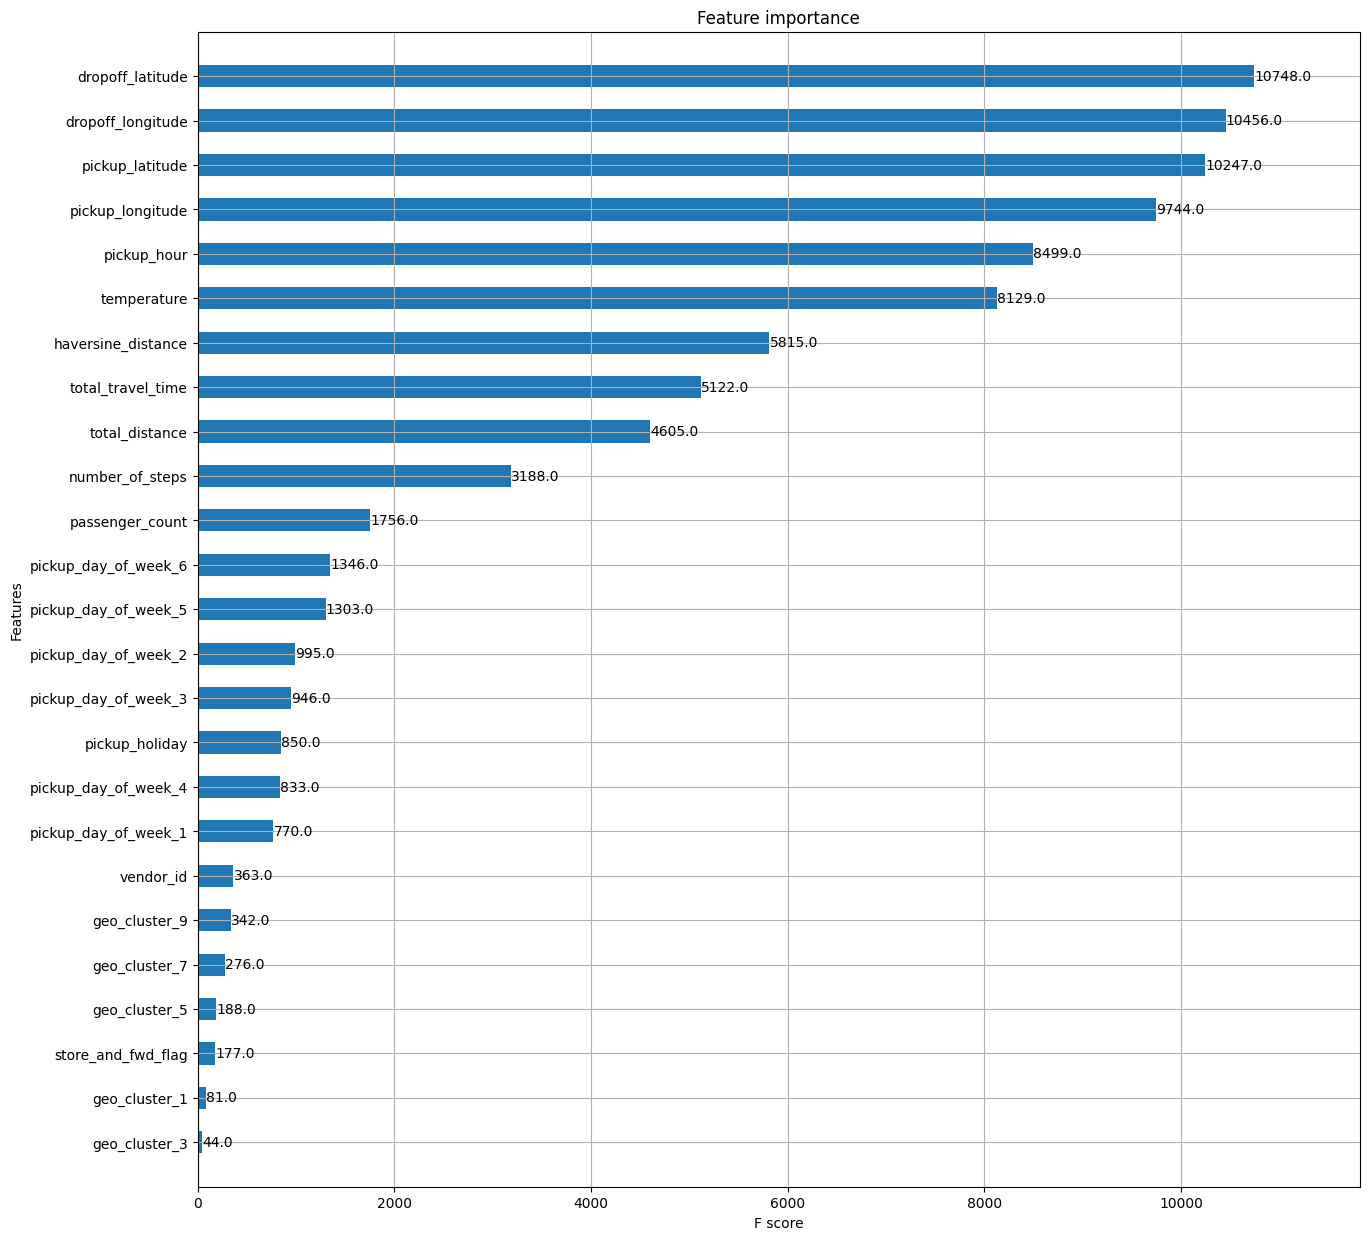

In [271]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)